In [1]:
'''
author: EdgardoCS @FSU Jena
date: 18.06.2025
'''

# install openpyxl

import bambi as bmb
import arviz as az
import itertools
import pingouin as pg
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels.genmod as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

import matplotlib as mpl
from matplotlib.cm import ScalarMappable
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from textwrap import wrap

pd.set_option('future.no_silent_downcasting', True)

In [2]:
input_data = 'output/data_sorted.xlsx'
columns = ['Id', 'Age', 'Rating', 'Gender', 'Segment', 'Location', 'Type']

data = pd.read_excel(input_data, usecols=columns)

# focus on Female and Male for now
data = (data[data['Gender'].isin(['Female', 'Male'])])
data.loc[data['Segment'] == "Face", 'Segment'] = "Head"

In [3]:
n = len(data["Id"].unique())
print(n)
# 2409 subjects

2409


In [4]:
# data["Segment"].value_counts()

In [5]:
# data["Location"].value_counts()

In [6]:
# data["Type"].value_counts()

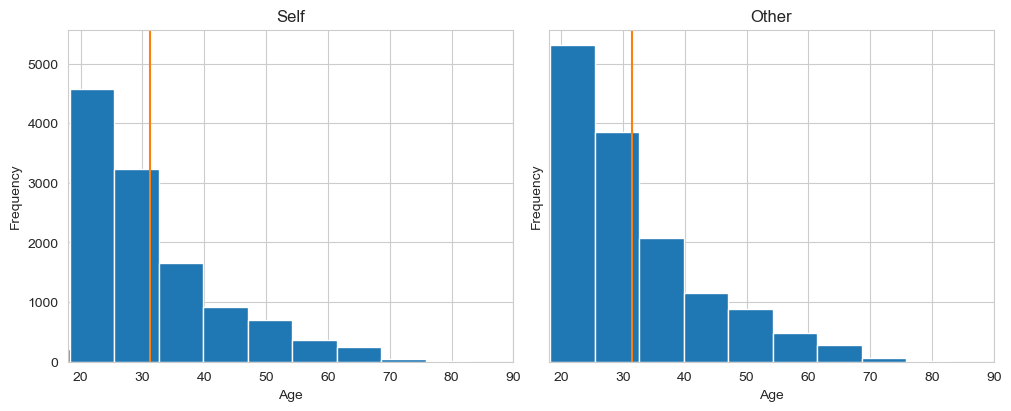

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharey=True, constrained_layout=True)
key = dict(zip(data["Type"].unique(), range(3)))
for label, df in data.groupby("Type"):
    ax[key[label]].hist(df["Age"])
    ax[key[label]].set_xlim([18, 90])
    ax[key[label]].set_xlabel("Age")
    ax[key[label]].set_ylabel("Frequency")
    ax[key[label]].set_title(label)
    ax[key[label]].axvline(df["Age"].mean(), color="C1")
plt.savefig('output/distribution_age.png', dpi=350, bbox_inches='tight')

In [8]:
# Define all factor levels
types = data["Type"].unique()
segments = data["Segment"].unique()
locations = data["Location"].unique()

In [9]:
# Build full grid for each subject × all combinations of the 3 factors
all_combos = pd.DataFrame([
    (i, g, t, l)
    for i in data['Id'].unique()
    for g, t, l in itertools.product(types, locations, segments)
], columns=['Id', 'Type', 'Location', 'Segment'])

# Add indicator of whether that combination was rated
data['Marked'] = (data['Rating'] > 0).astype(int)

# Merge data with all possible combinations
merged = all_combos.merge(
    data[['Id', 'Type', 'Location', 'Segment', 'Marked']],
    on=['Id', 'Type', 'Location', 'Segment'],
    how='left'
)

In [10]:
# Add Age and Gender, avoid duplicate data
merged = merged.merge(
    data[['Id', 'Type', 'Location', 'Segment', 'Age', 'Gender']],
    on=['Id', 'Type', 'Location', 'Segment'],
    how='left'
)
# Fill for all
merged['Age'] = merged.groupby('Id')['Age'].transform(lambda x: x.ffill().bfill())
merged['Gender'] = merged.groupby('Id')['Gender'].transform(lambda x: x.ffill().bfill())

# Fill missing with 0 = not marked
merged['Marked'] = merged['Marked'].fillna(0).astype(int)

In [11]:
female_df = merged[merged['Gender'] == 'Female'].copy()
male_df = merged[merged['Gender'] == 'Male'].copy()

In [12]:
female_n = len(female_df["Id"].unique())
male_n = len(male_df["Id"].unique())
print('females', female_n)
print('males', male_n)

females 1524
males 885


In [13]:
# pd.crosstab(female_df["Segment"], female_df["Marked"])
pd.crosstab(
    index=female_df["Segment"],
    columns=[female_df["Marked"], female_df["Location"]]
)

Marked       0           1      
Location  Back Front  Back Front
Segment                         
Armpits   1669   254  1379  2794
Chest     2554  2353   494   695
Feet      1898  1322  1150  1726
Genitals  1925  1288  1123  1760
Hands     2489  1989   559  1059
Head      2361  1606   687  1442
Legs      2856  2880   192   168
Neck      2339  2004   709  1044

In [14]:
# pd.crosstab(male_df["Segment"], male_df["Marked"])
pd.crosstab(
    index=male_df["Segment"],
    columns=[male_df["Marked"], male_df["Location"]]
)

Marked       0          1      
Location  Back Front Back Front
Segment                        
Armpits    960   204  810  1566
Chest     1442  1397  328   373
Feet      1142   866  628   904
Genitals  1085   839  685   931
Hands     1502  1252  268   518
Head      1458  1026  312   744
Legs      1649  1672  121    98
Neck      1328  1167  442   603

In [15]:
# For Pie charts
colors = sns.color_palette('YlGnBu_d')[1:3]

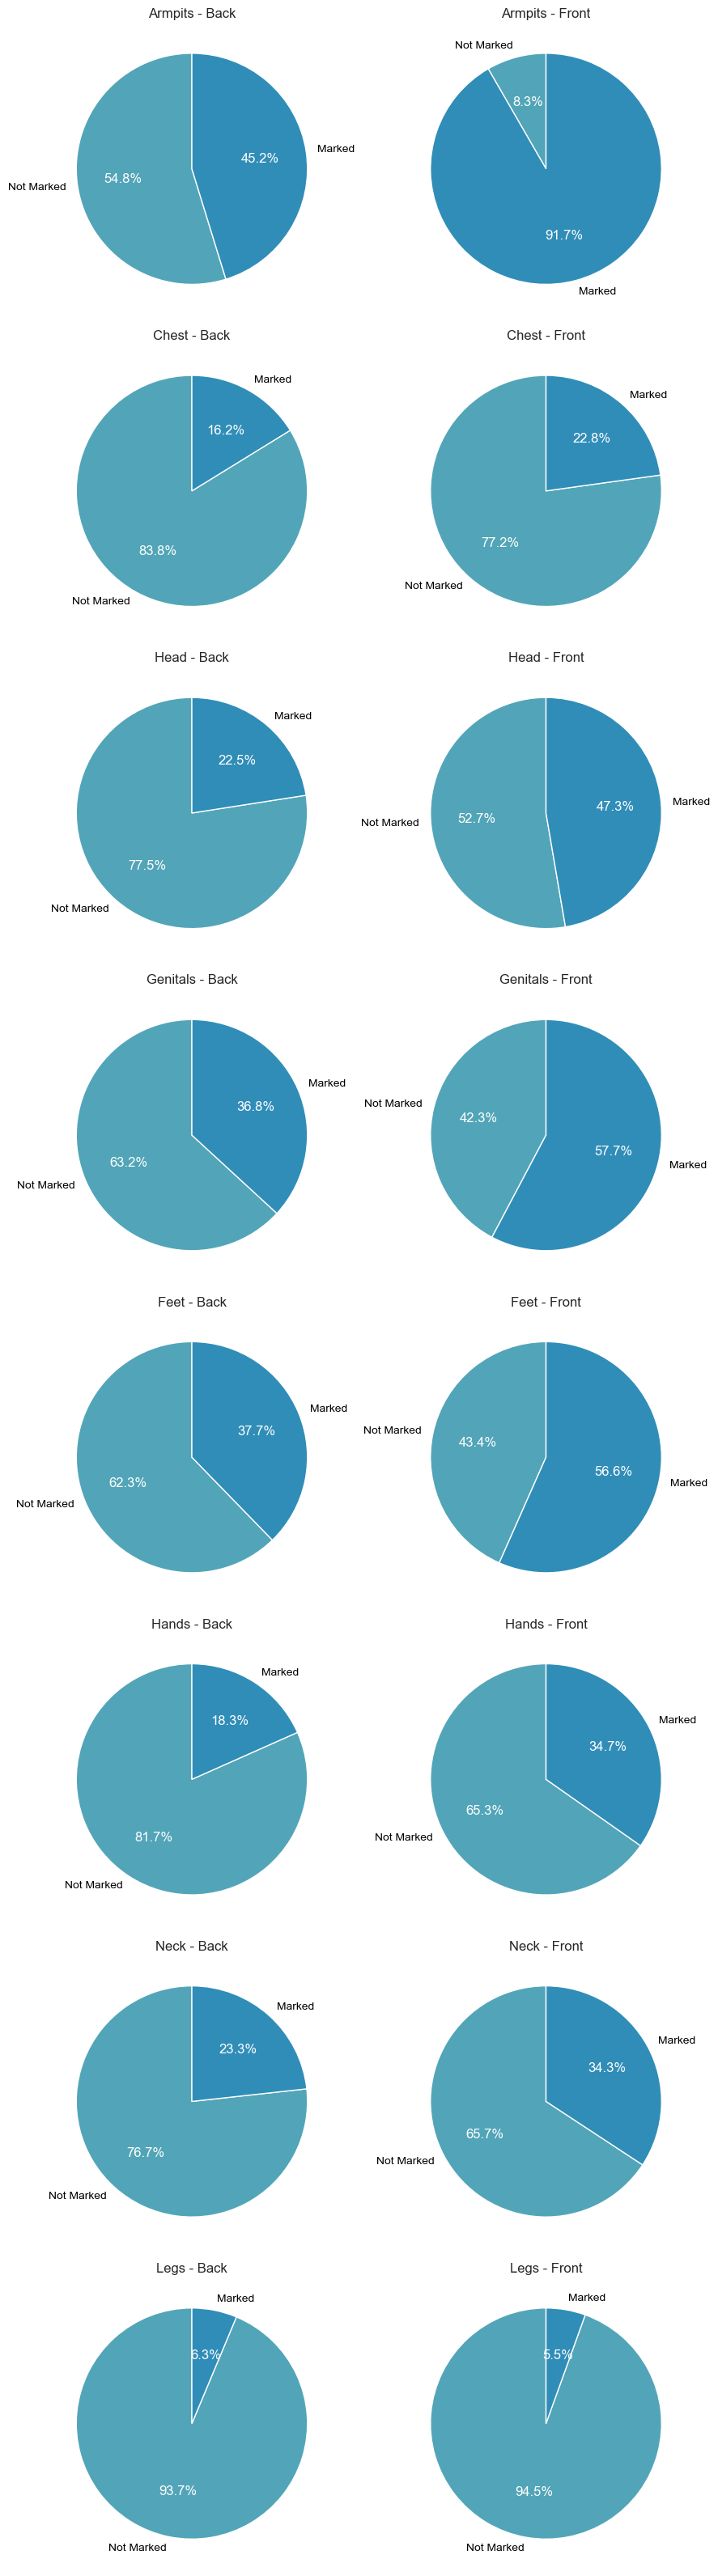

In [16]:
# Setup grid of subplots
fig, axes = plt.subplots(nrows=len(segments), ncols=len(locations), figsize=(8 * len(locations), 4 * len(segments)))
plt.tight_layout()

# Make sure axes is always 2D
if len(segments) == 1:
    axes = [axes]
if len(locations) == 1:
    axes = [[ax] for ax in axes]

# Plot
for i, segment in enumerate(segments):
    for j, location in enumerate(locations):
        ax = axes[i][j]
        subset = female_df[(female_df["Segment"] == segment) & (female_df["Location"] == location)]
        counts = subset["Marked"].value_counts().sort_index()

        labels = ["Not Marked", "Marked"]
        wedges, texts, autotexts = ax.pie(
            counts,
            labels=labels,
            autopct="%1.1f%%",
            startangle=90,
            textprops={"color": "black"},
            colors=colors
        )

        # Set percentage text to white inside slices
        for autotext in autotexts:
            autotext.set_color("white")
            autotext.set_fontsize("large")
        ax.set_title(f"{segment} - {location}")

fig.subplots_adjust(wspace=-0.6)
plt.savefig('output/pie-female.png', dpi=350, bbox_inches='tight')
plt.show()

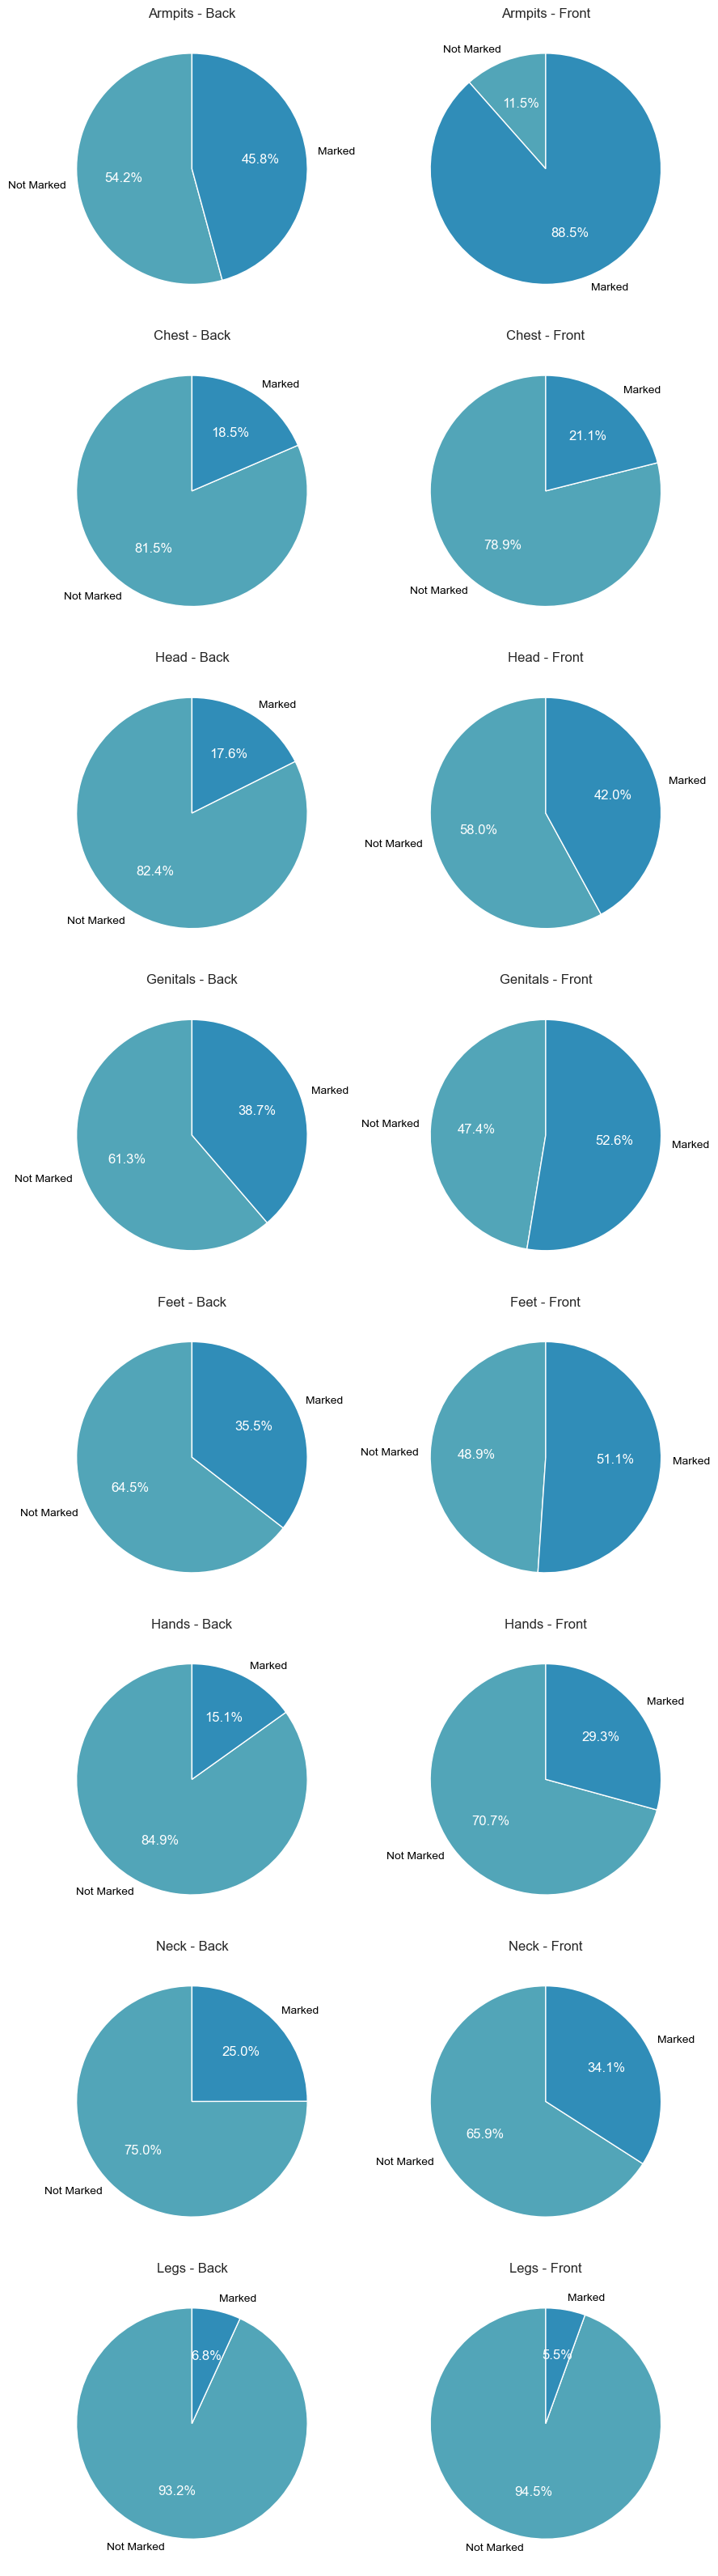

In [17]:
# Setup grid of subplots
fig, axes = plt.subplots(nrows=len(segments), ncols=len(locations), figsize=(8 * len(locations), 4 * len(segments)))
plt.tight_layout()
# Make sure axes is always 2D
if len(segments) == 1:
    axes = [axes]
if len(locations) == 1:
    axes = [[ax] for ax in axes]

# Plot
for i, segment in enumerate(segments):
    for j, location in enumerate(locations):
        ax = axes[i][j]
        subset = male_df[(male_df["Segment"] == segment) & (male_df["Location"] == location)]
        counts = subset["Marked"].value_counts().sort_index()

        labels = ["Not Marked", "Marked"]
        wedges, texts, autotexts = ax.pie(
            counts,
            labels=labels,
            autopct="%1.1f%%",
            startangle=90,
            textprops={"color": "black"},
            colors=colors
        )
        # Set percentage text to white inside slices
        for autotext in autotexts:
            autotext.set_color("white")
            autotext.set_fontsize("large")
        ax.set_title(f"{segment} - {location}")

fig.subplots_adjust(wspace=-0.6)
plt.savefig('output/pie-male.png', dpi=350, bbox_inches='tight')
plt.show()

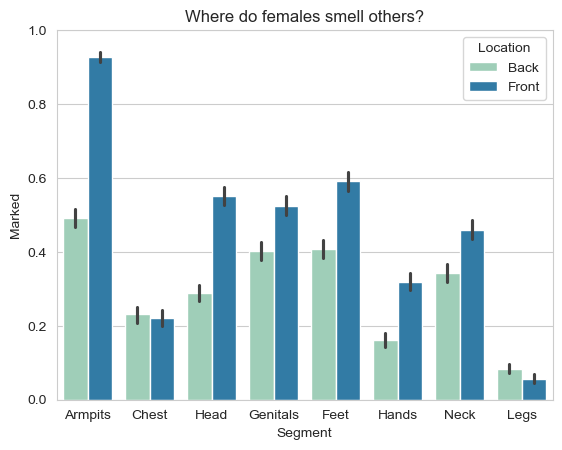

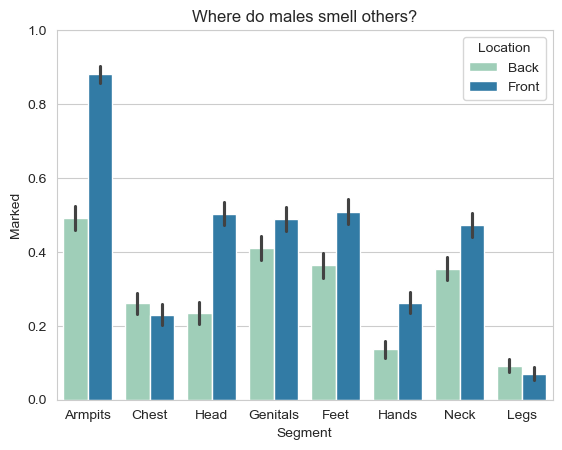

In [18]:
sns.barplot(
    data=female_df[female_df['Type'] == 'Other'],
    hue="Location",
    x="Segment",
    y="Marked",
    palette='YlGnBu'
)
plt.ylim(0, 1)
plt.title('Where do females smell others?')
plt.savefig('output/bars-female-others.png', dpi=350, bbox_inches='tight')
plt.show()

sns.barplot(
    data=male_df[male_df['Type'] == 'Other'],
    hue="Location",
    x="Segment",
    y="Marked",
    palette='YlGnBu'
)
plt.ylim(0, 1)
plt.title('Where do males smell others?')
plt.savefig('output/bars-male-others.png', dpi=350, bbox_inches='tight')
plt.show()

In [19]:
colors = [sns.color_palette('YlGnBu_d')[0], sns.color_palette('YlGnBu_d')[3]]

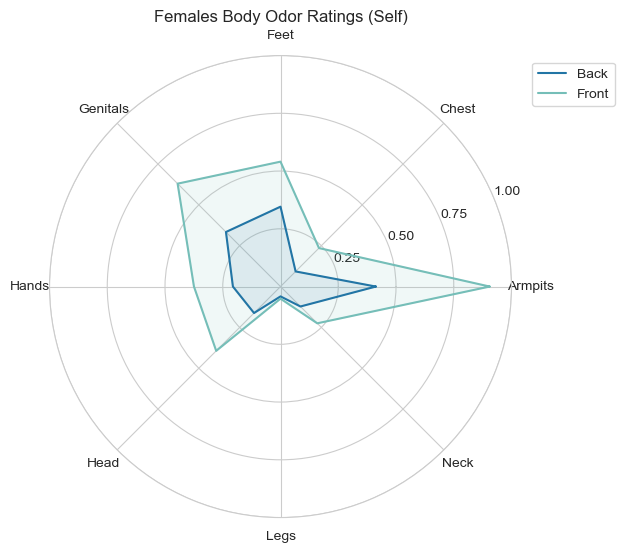

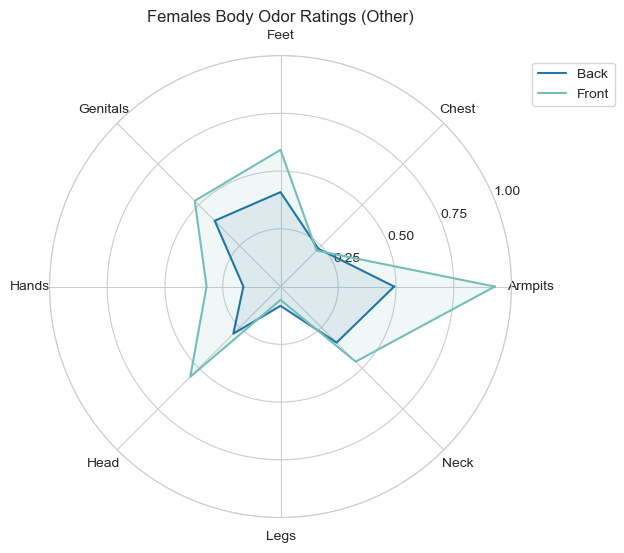

In [20]:
female_radar = female_df.groupby(['Segment', 'Location', 'Type'])['Marked']
estimates = female_radar.mean().reset_index()
estimates = estimates.rename(columns={'Marked': 'Mean_Marked'})

for i, t in enumerate(types):
    pivot_df = estimates[estimates['Type'] == t].pivot(
        index='Location',
        columns='Segment',
        values='Mean_Marked'
    )
    categories = list(pivot_df.columns)
    N = len(categories)

    angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

    for idx, row in pivot_df.iterrows():
        values = row.tolist()
        values += values[:1]
        if idx == "Front":
            ax.plot(angles, values, label=idx, color=colors[0])
            ax.fill(angles, values, alpha=0.1, color=colors[0])
        elif idx == "Back":
            ax.plot(angles, values, label=idx, color=colors[1])
            ax.fill(angles, values, alpha=0.1, color=colors[1])

    ticks = [0.25, 0.50, 0.75, 1]
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories)
    ax.set_yticks(ticks)
    ax.set_title(f'Females Body Odor Ratings ({t})')
    ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
    plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
    plt.savefig('output/radar-female-' + t + '.png', dpi=350, bbox_inches='tight')
    plt.show()

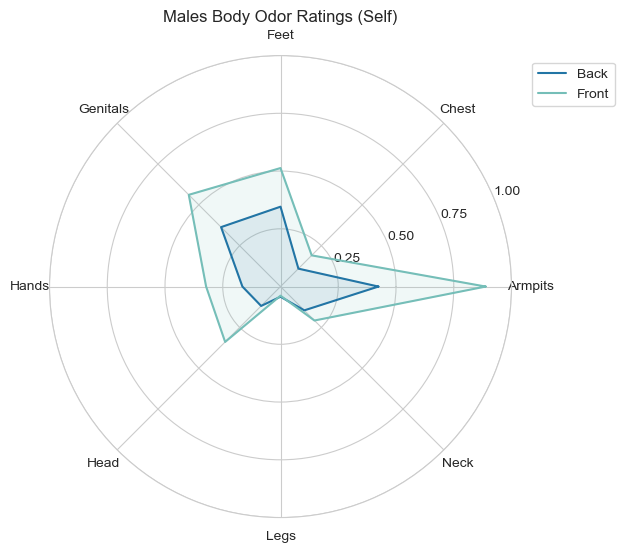

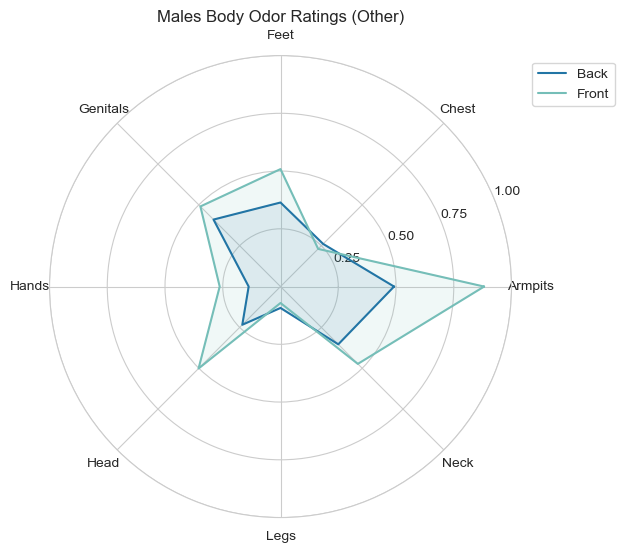

In [21]:
male_radar = male_df.groupby(['Segment', 'Location', 'Type'])['Marked']
estimates = male_radar.mean().reset_index()
estimates = estimates.rename(columns={'Marked': 'Mean_Marked'})

for i, t in enumerate(types):
    pivot_df = estimates[estimates['Type'] == t].pivot(
        index='Location',
        columns='Segment',
        values='Mean_Marked'
    )
    categories = list(pivot_df.columns)
    N = len(categories)

    angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

    for idx, row in pivot_df.iterrows():
        values = row.tolist()
        values += values[:1]
        if idx == "Front":
            ax.plot(angles, values, label=idx, color=colors[0])
            ax.fill(angles, values, alpha=0.1, color=colors[0])
        elif idx == "Back":
            ax.plot(angles, values, label=idx, color=colors[1])
            ax.fill(angles, values, alpha=0.1, color=colors[1])

    ticks = [0.25, 0.50, 0.75, 1]
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories)
    ax.set_yticks(ticks)
    ax.set_title(f'Males Body Odor Ratings ({t})')
    ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
    plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
    plt.savefig('output/radar-male-' + t + '.png', dpi=350, bbox_inches='tight')
    plt.show()

In [22]:
female_density = (
    female_df.groupby(['Id', 'Type', 'Location', 'Age'])['Marked'].value_counts()
    .unstack(fill_value=0)
    .rename(columns={0: 'Unmarked', 1: 'Marked'})
    .reset_index()
)

female_wide = female_density.pivot(index='Id', columns=['Type', 'Location'], values='Marked')

age_map = female_density.groupby('Id')['Age'].first()
female_wide['Age'] = female_wide.index.map(age_map)

print('female cronbach', pg.cronbach_alpha(data=female_wide))

male_density = (
    male_df.groupby(['Id', 'Type', 'Location', 'Age'])['Marked'].value_counts()
    .unstack(fill_value=0)
    .rename(columns={0: 'Unmarked', 1: 'Marked'})
    .reset_index()
)

male_wide = male_density.pivot(index='Id', columns=['Type', 'Location'], values='Marked')

age_map = male_density.groupby('Id')['Age'].first()
male_wide['Age'] = male_wide.index.map(age_map)

print('male cronbach', pg.cronbach_alpha(data=male_wide))

female cronbach (np.float64(0.022766523062454497), array([-0.057,  0.098]))
male cronbach (np.float64(0.030822095413042677), array([-0.074,  0.128]))


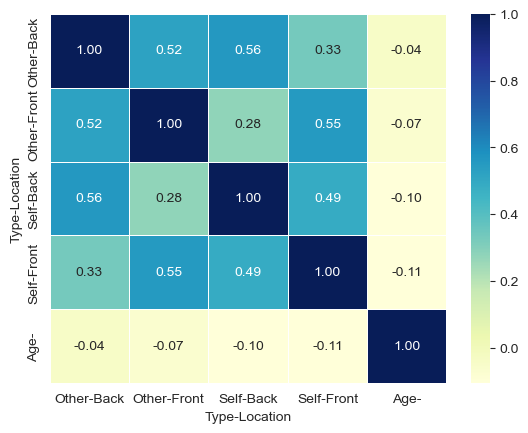

In [23]:
correlation = female_wide.corr()
sns.heatmap(correlation, cmap='YlGnBu', fmt='.2f',
            linewidths=0.5, annot_kws={"size": 10},
            annot=True,
            )
plt.grid(False)

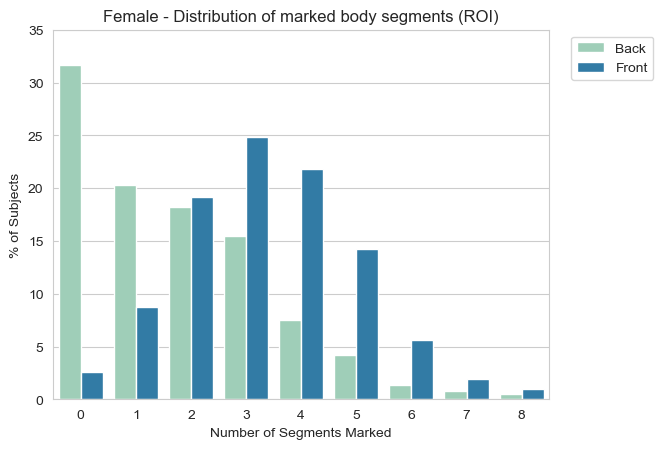

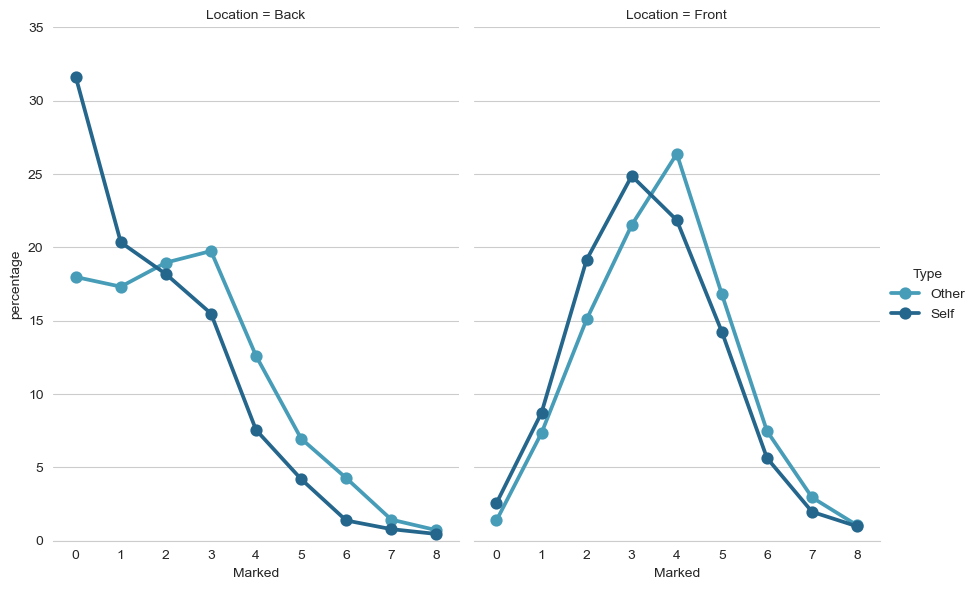

In [25]:
female_distribution = female_density.groupby(['Location', 'Type'], as_index=False)['Marked'].value_counts()
female_distribution["percentage"] = round(female_distribution['count'].transform(lambda x: x * 100 / female_n), 2)

sns.barplot(data=female_distribution[female_distribution["Type"] == "Self"], x="Marked", y="percentage", hue="Location",
            palette='YlGnBu')
plt.xlabel("Number of Segments Marked")
plt.ylabel("% of Subjects")
plt.ylim([0, 35])
plt.title("Female - Distribution of marked body segments (ROI)")
plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
plt.show()

g = sns.catplot(
    data=female_distribution, x="Marked", y="percentage", hue="Type", col="Location",
    capsize=.2, palette="YlGnBu_d", errorbar="se",
    kind="point", height=6, aspect=.75,
)
g.despine(left=True)
plt.ylim([0, 35])
plt.savefig('output/cat-female-marked.png', dpi=350, bbox_inches='tight')
plt.show()

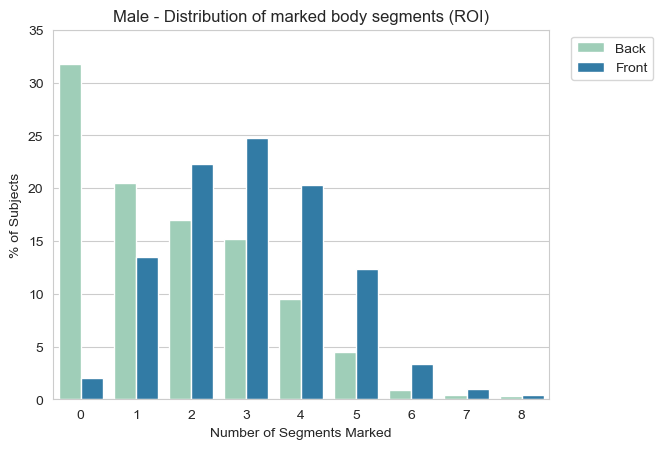

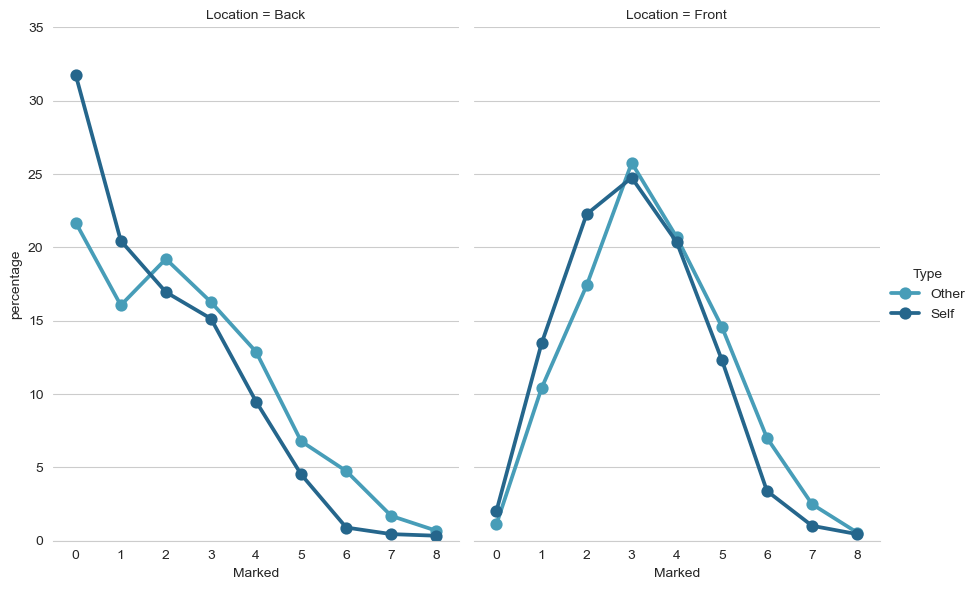

In [26]:
male_distribution = male_density.groupby(['Location', 'Type'], as_index=False)['Marked'].value_counts()
male_distribution["percentage"] = round(male_distribution['count'].transform(lambda x: x * 100 / male_n), 2)

sns.barplot(data=male_distribution[male_distribution["Type"] == "Self"], x="Marked", y="percentage", hue="Location",
            palette='YlGnBu')
plt.xlabel("Number of Segments Marked")
plt.ylabel("% of Subjects")
plt.ylim([0, 35])
plt.title("Male - Distribution of marked body segments (ROI)")
plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
plt.show()

g = sns.catplot(
    data=male_distribution, x="Marked", y="percentage", hue="Type", col="Location",
    capsize=.2, palette="YlGnBu_d", errorbar="se",
    kind="point", height=6, aspect=.75,
)
g.despine(left=True)
plt.ylim([0, 35])
plt.savefig('output/cat-male-marked.png', dpi=350, bbox_inches='tight')
plt.show()

In [27]:
model = bmb.Model(
    "Marked ~ Location + Location:Age",
    data=female_density,
    family="poisson"
)

model_fitted = model.fit(draws=2000, target_accept=0.85, idata_kwargs={"log_likelihood": True})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, Location, Location:Age]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 39 seconds.


In [28]:
age = np.linspace(18, 80)
predict_df = pd.DataFrame({
    "Age": np.tile(age, 2),
    "Location": np.repeat(["Front", "Back"], len(age))
})

,Age,Location
0,18.000000,Front
1,19.265306,Front
2,20.530612,Front
3,21.795918,Front
4,23.061224,Front
...,...,...
95,74.938776,Back
96,76.204082,Back
97,77.469388,Back
98,78.734694,Back


In [29]:
predict_df["Id"] = 0
model.predict(model_fitted, data=predict_df, sample_new_groups=True)
az.summary(model_fitted)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.891,0.037,0.822,0.959,0.001,0.000,4495.0,4365.0,1.0
Location[Front],0.470,0.046,0.381,0.554,0.001,0.001,4278.0,4336.0,1.0
Location:Age[Back],-0.005,0.001,-0.007,-0.003,0.000,0.000,4472.0,4409.0,1.0
Location:Age[Front],-0.003,0.001,-0.005,-0.002,0.000,0.000,5246.0,5040.0,1.0
mu[0],3.669,0.054,3.571,3.773,0.001,0.001,5734.0,5774.0,1.0
...,...,...,...,...,...,...,...,...,...
mu[95],1.632,0.084,1.475,1.789,0.001,0.001,4665.0,4468.0,1.0
mu[96],1.621,0.085,1.461,1.781,0.001,0.001,4656.0,4469.0,1.0
mu[97],1.610,0.087,1.446,1.772,0.001,0.001,4650.0,4483.0,1.0
mu[98],1.600,0.089,1.432,1.764,0.001,0.001,4644.0,4469.0,1.0


In [30]:
posterior = az.extract(model_fitted, num_samples=2000)["mu"]

<xarray.DataArray 'mu' (__obs__: 100, sample: 2000)> Size: 2MB
array([[3.75235466, 3.70383454, 3.66762214, ..., 3.66609   , 3.68255227,
        3.82318301],
       [3.73441911, 3.68806776, 3.65046   , ..., 3.65018645, 3.66309378,
        3.79334849],
       [3.71656928, 3.67236811, 3.63337816, ..., 3.63435189, 3.64373811,
        3.76374679],
       ...,
       [1.57055147, 1.77228836, 1.60569159, ..., 1.57129903, 1.73869776,
        1.59110553],
       [1.55922418, 1.76510419, 1.59403426, ..., 1.56028131, 1.73090899,
        1.58046918],
       [1.54797858, 1.75794913, 1.58246156, ..., 1.54934084, 1.7231551 ,
        1.56990393]], shape=(100, 2000))
Coordinates:
  * __obs__  (__obs__) int64 800B 0 1 2 3 4 5 6 7 8 ... 92 93 94 95 96 97 98 99
  * sample   (sample) object 16kB MultiIndex
  * chain    (sample) int64 16kB 2 0 3 1 2 1 3 0 2 2 0 ... 2 1 1 2 1 2 2 0 1 2 0
  * draw     (sample) int64 16kB 598 1210 1290 579 1857 ... 1123 835 443 1863

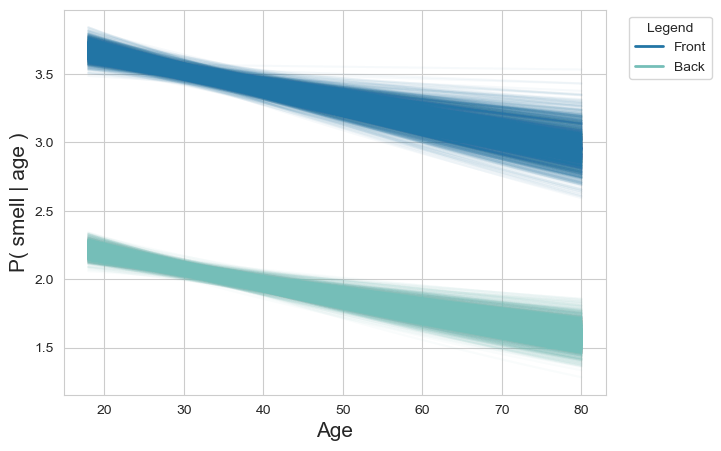

In [36]:
_, ax = plt.subplots(figsize=(7, 5))
for i, location in enumerate(locations):
    idx = predict_df.index[predict_df["Location"] == location].tolist()
    ax.plot(age, posterior[idx], alpha=0.04, color=colors[i])

ax.set_ylabel("P ( smell | age )", fontsize=15)
ax.set_xlabel("Age", fontsize=15)

custom_legend = [
    Line2D([0], [0], color=colors[1], lw=2, label='Front'),
    Line2D([0], [0], color=colors[0], lw=2, label='Back')
]

plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1), handles=custom_legend, title="Legend")
plt.savefig('output/stats/prediction_age.png', dpi=350, bbox_inches='tight')
plt.show()

In [32]:
# Logistic mixed-effects model
model = smf.glm(
    "Marked ~ Segment * Gender * Location * Type",
    data=merged,
    family=sm.families.Binomial()
)
model_fit = model.fit()
print(model_fit.summary())

# Reference: Female, Others, armpit
# Intercept -0,0315, p = 0.539 (ns)

# Location (front)   2,585, p < 0.001 (***)
# Type (Self)       -0,321, p < 0.001 (***)
# Gender (Male)     -0,002, p = 0,977 (ns)
# β, p

# There is a significant effect of Type (Self, Other), and Location (Front, Back). However, no significant effect of Gender (Female, Male) is observed
# # Compared to the highest rated Segment, armpit, the rest of the segments were rated significantly lower.
# Segment[T.chest]  -1,167,    p < 0.001 (***)
# Segment[T.feet]   -0,337,    p < 0.001 (***)
# Segment[T.hair]   -1,067,    p < 0.001 (***)
# Segment[T.hand]   -1,621,    p < 0.001 (***)
# Segment[T.legs]   -2,366,    p < 0.001 (***)
# Segment[T.mouth]  -1,954,    p < 0.001 (***)
# Segment[T.neck]   -0,617,    p < 0.001 (***)
# Segment[T.pelvis] -0,362,    p < 0.001 (***)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 Marked   No. Observations:                77088
Model:                            GLM   Df Residuals:                    77024
Model Family:                Binomial   Df Model:                           63
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -40846.
Date:                Thu, 26 Jun 2025   Deviance:                       81691.
Time:                        16:03:37   Pearson chi2:                 7.71e+04
No. Iterations:                     6   Pseudo R-squ. (CS):             0.2008
Covariance Type:            nonrobust                                         
                                                                        coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------

In [33]:
check = pd.crosstab([merged['Segment'], merged['Location']], merged['Marked'])
print(check)

Marked                0     1
Segment  Location            
Armpits  Back      2629  2189
         Front      458  4360
Chest    Back      3996   822
         Front     3750  1068
Feet     Back      3040  1778
         Front     2188  2630
Genitals Back      3010  1808
         Front     2127  2691
Hands    Back      3991   827
         Front     3241  1577
Head     Back      3819   999
         Front     2632  2186
Legs     Back      4505   313
         Front     4552   266
Neck     Back      3667  1151
         Front     3171  1647


In [34]:
# 1. Is there any difference between Female and Male when smelling Others?
target1 = (merged[
               (merged['Type'] == 'Other') &
               (merged['Gender'].isin(['Female', 'Male']))]
           .copy())
# same model, only for type others
model1 = smf.glm("Marked ~ Segment * Location * Gender",
                 data=target1,
                 family=sm.families.Binomial()).fit()
# model1_fit = model1.fit()
print(model1.summary())

# Location (front)    0.436, p < 0.001 (***)
# Gender (Male)      -0.001, p = 0.974 (ns)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 Marked   No. Observations:                38544
Model:                            GLM   Df Residuals:                    38512
Model Family:                Binomial   Df Model:                           31
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -21595.
Date:                Thu, 26 Jun 2025   Deviance:                       43189.
Time:                        16:03:38   Pearson chi2:                 3.85e+04
No. Iterations:                     6   Pseudo R-squ. (CS):             0.1811
Covariance Type:            nonrobust                                         
                                                           coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------

In [41]:
# def calculate_p(input, fixed, condition):
#     # Coefficients:
#     for segment in condition:
#         b_fixed = input.params[fixed]
#         b_interaction = input.params['Segment[T.'+segment+']:Gender[T.Male]']
#
#         # Variance-covariance matrix:
#         cov = input.cov_params()
#
#         # Variances and covariance:
#         var_gender = cov.loc['Gender[T.Male]', 'Gender[T.Male]']
#         var_interaction = cov.loc['Segment[T.'+segment+']:Gender[T.Male]', 'Segment[T.'+segment+']:Gender[T.Male]']
#         covar = cov.loc['Gender[T.Male]', 'Segment[T.'+segment+']:Gender[T.Male]']
#
#         # Combined coefficient and SE:
#         beta_sum = b_fixed + b_interaction
#         se_sum = np.sqrt(var_gender + var_interaction + 2 * covar)
#
#         # z and p values:
#         z = beta_sum / se_sum
#         p = 2 * stats.norm.sf(abs(z))
#         return
#         print(f'Combined coef: {beta_sum:.4f}, SE: {se_sum:.4f}, z: {z:.4f}, p-value: {p:.4f}')
#
# # Lets compare each segment for Location. Since we know that type has effect and Gender has no effect.
# fixed = ['Gender[T.Male]']
# Segments = ["Head", "Feet"]
# a = calculate_p(model1, fixed, Segments)

# Store results here
contrast_results = []

# Get parameter names from the model
param_names = model1.params.index

# Identify all segment levels (excluding reference)
segment_levels = [name for name in param_names if name.startswith("Segment[T.") and ":Gender" not in name]

# Get the name of the reference segment (not in the param_names)
all_segments = target1['Segment'].unique()
used_segments = [s.split("[T.")[1].strip("]") for s in segment_levels]
ref_segment = list(set(all_segments) - set(used_segments))[0]

print(f"Reference Segment (not shown in model): {ref_segment}")

# Add the reference segment manually to the list for looping
segments_to_check = used_segments + [ref_segment]

# Loop through each segment and test gender difference
for seg in segments_to_check:
    # Initialize contrast vector with zeros
    contrast_vec = np.zeros(len(param_names))

    # Add 1 for main effect of Gender[T.Male]
    if "Gender[T.Male]" in param_names:
        contrast_vec[param_names.get_loc("Gender[T.Male]")] = 1

    # For non-reference segments, add interaction term
    interaction_term = f"Segment[T.{seg}]:Gender[T.Male]"
    if interaction_term in param_names:
        contrast_vec[param_names.get_loc(interaction_term)] = 1
    # For reference segment (no Segment[T.X] term), no interaction term to add

    # Run the t-test
    test = model1.t_test(contrast_vec)
    test_result = test.summary_frame()

    # Store results
    contrast_results.append({
        "Segment": seg,
        "Coef": test_result["coef"].values[0],
        "StdErr": test_result["std err"].values[0],
        "z": test_result["z"].values[0],
        "p_value": test_result["P>|z|"].values[0],
        "CI_lower": test_result["[0.025"].values[0],
        "CI_upper": test_result["0.975]"].values[0]
    })

# Convert to DataFrame
contrast_df = pd.DataFrame(contrast_results)
contrast_df = contrast_df.sort_values("p_value")

# Show the result
print(contrast_df)

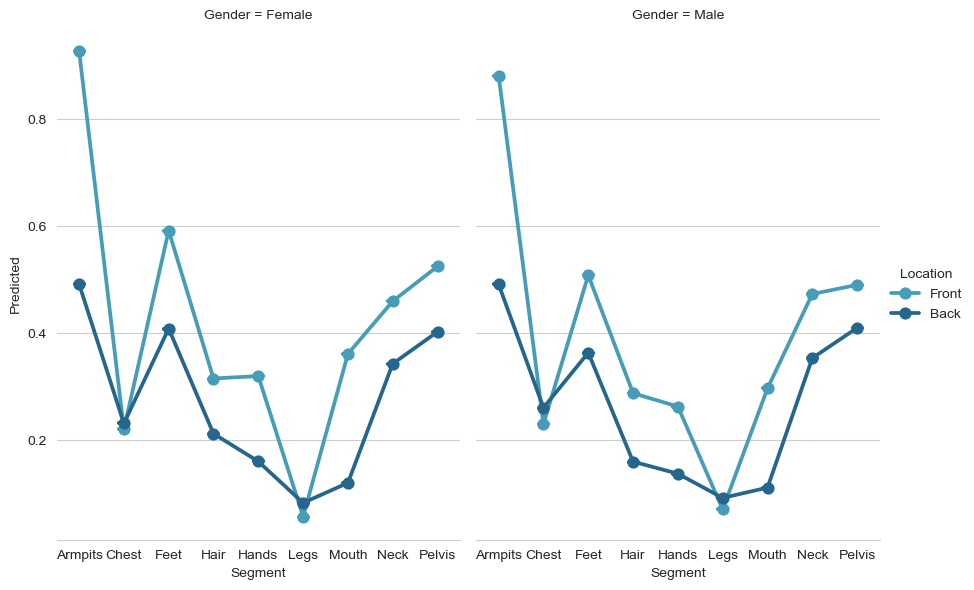

In [101]:
predict_df = target1.copy()
predict_df["Id"] = 0  # Dummy ID for prediction

# Predict with fixed effects only (excluding random effects)
predictions = model1_fit.predict(predict_df)

# Attach predictions
predict_df["Predicted"] = predictions

g = sns.catplot(
    data=predict_df, x="Segment", y="Predicted", hue="Location", col="Gender",
    capsize=.2, palette="YlGnBu_d", errorbar="se",
    kind="point", height=6, aspect=.75,
)
g.despine(left=True)
plt.show()

# plt.savefig('output/stats/pointplot-others-gender.png', bbox_inches='tight', dpi=300)
# plt.show()

In [50]:
# 2. Is there any difference between Female and Male when smelling Themselves?
target2 = (merged[
               (merged['Type'] == 'Self') &
               (merged['Gender'].isin(['Female', 'Male']))]
           .copy())
# same model, only for type others
model2 = smf.mixedlm(
    "Marked ~ Segment * Location * Gender",
    target2,
    groups=target2["Id"]
)
model2_fit = model2.fit()

print(model2_fit.summary())

# Location (front)   0.493, p < 0.001 (***)
# Gender (Male)      0.011, p = 0.508 (ns)
# β, p
# Compared to the highest rated Segment, Armpit, the rest of the segments were rated significantly lower when smelling themselves.
# Segment[T.chest]  -0.320,    p < 0.001 (***)
# Segment[T.feet]   -0.067,    p < 0.001 (***)
# Segment[T.hair]   -0.288,    p < 0.001 (***)
# Segment[T.hand]   -0.207,    p < 0.001 (***)
# Segment[T.legs]   -0.370,    p < 0.001 (***)
# Segment[T.mouth]  -0.346,    p < 0.001 (***)
# Segment[T.neck]   -0.291,    p < 0.001 (***)
# Segment[T.pelvis] -0.079,    p < 0.001 (***)

# All segments were rated significantly higher in front.
# Segment[T.chest]:Location[T.Front]   -0.350,   p < 0.001 (***)
# Segment[T.feet]:Location[T.Front]    -0.298,   p < 0.001 (***)
# Segment[T.hair]:Location[T.Front]    -0.419,   p < 0.001 (***)
# Segment[T.hand]:Location[T.Front]    -0.324,   p < 0.001 (***)
# Segment[T.legs]:Location[T.Front]    -0.483,   p < 0.001 (***)
# Segment[T.mouth]:Location[T.Front]   -0.278,   p < 0.001 (***)
# Segment[T.neck]:Location[T.Front]    -0.390,   p < 0.001 (***)
# Segment[T.pelvis]:Location[T.Front]  -0.197,   p < 0.001 (***)

# Gender appears to have no significance overall, although hair was rated significantly higher for females
# Segment[T.Chest]:Gender[T.Male]                     0.006   0.782
# Segment[T.Feet]:Gender[T.Male]                     -0.011   0.617
# Segment[T.Hair]:Gender[T.Male]                     -0.057   0.010 (**)
# Segment[T.Hands]:Gender[T.Male]                    -0.052   0.018
# Segment[T.Legs]:Gender[T.Male]                     -0.010   0.664
# Segment[T.Mouth]:Gender[T.Male]                    -0.019   0.384
# Segment[T.Neck]:Gender[T.Male]                      0.013   0.564
# Segment[T.Pelvis]:Gender[T.Male]                    0.019   0.392
# Location[T.Front]:Gender[T.Male]                   -0.028   0.198

                            Mixed Linear Model Regression Results
Model:                         MixedLM             Dependent Variable:             Marked     
No. Observations:              43362               Method:                         REML       
No. Groups:                    2409                Scale:                          0.1360     
Min. group size:               18                  Log-Likelihood:                 -19886.2913
Max. group size:               18                  Converged:                      Yes        
Mean group size:               18.0                                                           
----------------------------------------------------------------------------------------------
                                                   Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------------------------
Intercept                                           0.413    0.010  40.960 0.00

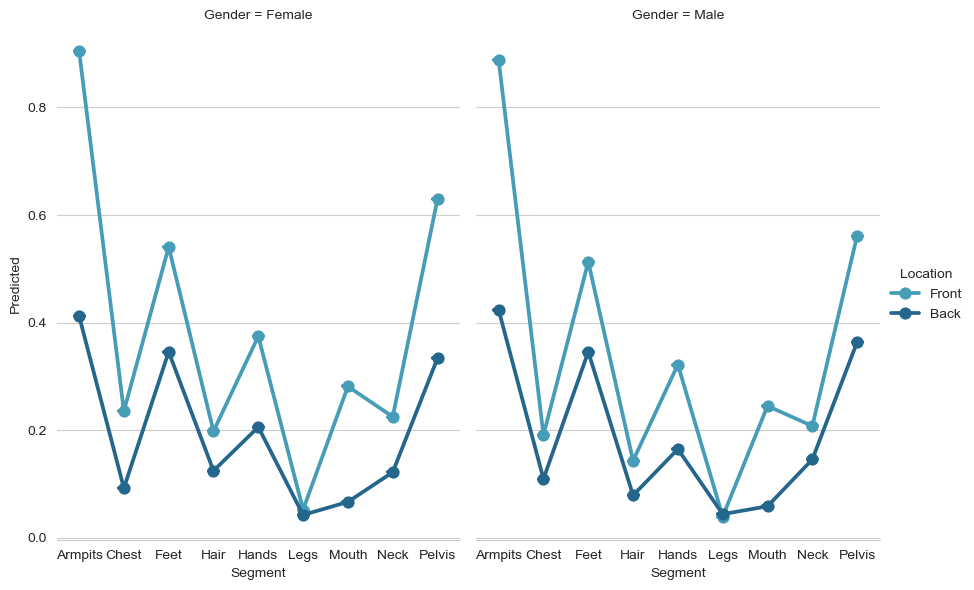

In [100]:
predict_df = target2.copy()
predict_df["Id"] = 0  # Dummy ID for prediction

# Predict with fixed effects only (excluding random effects)
predictions = model2_fit.predict(predict_df)

# Attach predictions
predict_df["Predicted"] = predictions

g = sns.catplot(
    data=predict_df, x="Segment", y="Predicted", hue="Location", col="Gender",
    capsize=.2, palette="YlGnBu_d", errorbar="se",
    kind="point", height=6, aspect=.75,
)
g.despine(left=True)
plt.show()

# plt.savefig('output/stats/pointplot-others-gender.png', bbox_inches='tight', dpi=300)
# plt.show()

In [ ]:
# 3. is there any difference when Males smell themselves vs when they smell Others?
target3 = (merged[
               (merged['Gender'] == 'Male')
           ]
           .copy())
# same model, only for type others
model3 = smf.mixedlm(
    "Marked ~ Segment * Location * Type",
    target3,
    groups=target3["Id"]
)
model3_fit = model3.fit()

print(model3_fit.summary())

# Segment[T.Chest]:Type[T.Self]                    -0.084    p = 0.001 (***)
# Segment[T.Feet]:Type[T.Self]                      0.050    p = 0.055
# Segment[T.Hair]:Type[T.Self]                     -0.014    p = 0.601
# Segment[T.Hands]:Type[T.Self]                     0.095    p < 0.001 (***)
# Segment[T.Legs]:Type[T.Self]                      0.019    p = 0.459
# Segment[T.Mouth]:Type[T.Self]                     0.015    p = 0.571
# Segment[T.Neck]:Type[T.Self]                     -0.140    p < 0.001 (***)
# Segment[T.Pelvis]:Type[T.Self]                    0.021    p = 0.408
# Location[T.Front]:Type[T.Self]                    0.075    p = 0.004 (**)

# Segment[T.Chest]:Location[T.Front]:Type[T.Self]   0.037    p = 0.309
# Segment[T.Feet]:Location[T.Front]:Type[T.Self]   -0.052    p = 0.156
# Segment[T.Hair]:Location[T.Front]:Type[T.Self]   -0.138    p < 0.001 (***)
# Segment[T.Hands]:Location[T.Front]:Type[T.Self]  -0.043    p = 0.242
# Segment[T.Legs]:Location[T.Front]:Type[T.Self]   -0.058    p = 0.116
# Segment[T.Mouth]:Location[T.Front]:Type[T.Self]  -0.073    p = 0.045 (*)
# Segment[T.Neck]:Location[T.Front]:Type[T.Self]   -0.132    p < 0.001 (***)
# Segment[T.Pelvis]:Location[T.Front]:Type[T.Self]  0.043    p = 0.242

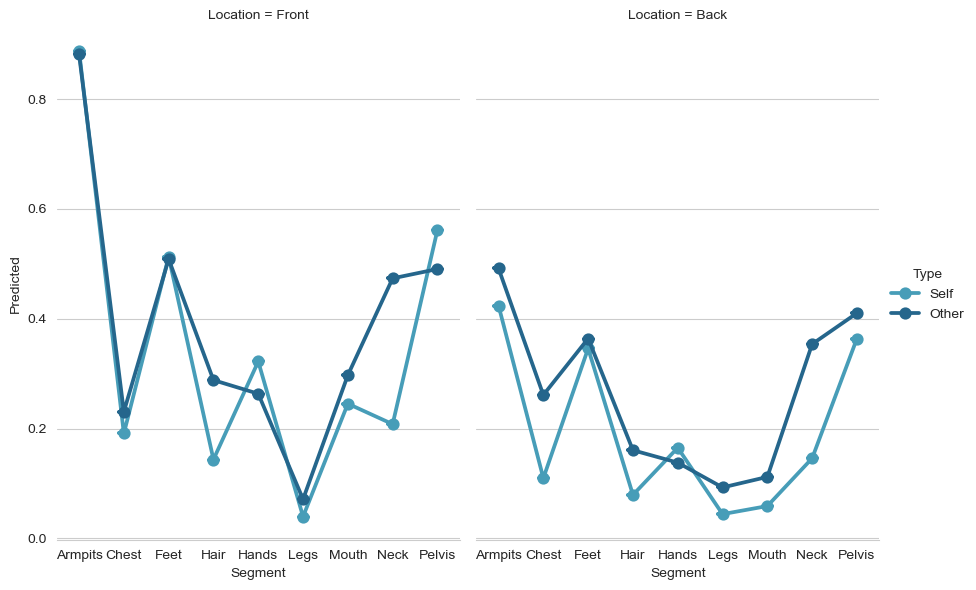

In [99]:
predict_df = target3.copy()
predict_df["Id"] = 0  # Dummy ID for prediction

# Predict with fixed effects only (excluding random effects)
predictions = model3_fit.predict(predict_df)

# Attach predictions
predict_df["Predicted"] = predictions

# sns.pointplot(
#     data=predict_df,
#     x="Segment",
#     hue="Type",
#     y="Predicted",
#     errorbar="sd",
#     palette='YlGnBu'
# )
# plt.title("Predicted Ratings by Segment and Location (Males)")
# plt.ylabel("Estimated Rating (Fixed Effects Only)")
# plt.savefig('output/stats/pointplot-others-location.png', bbox_inches='tight', dpi=300)
# plt.show()

g = sns.catplot(
    data=predict_df, x="Segment", y="Predicted", hue="Type", col="Location",
    capsize=.2, palette="YlGnBu_d", errorbar="se",
    kind="point", height=6, aspect=.75,
)
g.despine(left=True)
plt.show()

In [ ]:
# 4. is there any difference when Females smell themselves vs when they smell Others?
target4 = (merged[
               (merged['Gender'] == 'Female')
           ]
           .copy())
model4 = smf.mixedlm(
    "Marked ~ Segment * Location * Type",
    target4,
    groups=target4["Id"]
)
model4_fit = model4.fit()

print(model4_fit.summary())

# Segment[T.Chest]:Type[T.Self]                    -0.060    p = 0.003 (**)
# Segment[T.Feet]:Type[T.Self]                      0.016    p = 0.412
# Segment[T.Hair]:Type[T.Self]                     -0.009    p = 0.669
# Segment[T.Hands]:Type[T.Self]                     0.125    p < 0.001 (**)
# Segment[T.Legs]:Type[T.Self]                      0.039    p = 0.053
# Segment[T.Mouth]:Type[T.Self]                     0.026    p = 0.200
# Segment[T.Neck]:Type[T.Self]                     -0.142    p < 0.001 (***)
# Segment[T.Pelvis]:Type[T.Self]                    0.010    p = 0.599
# Location[T.Front]:Type[T.Self]                    0.057    p = 0.004 (**)
#
# Segment[T.Chest]:Location[T.Front]:Type[T.Self]   0.097    p = 0.001 (**)
# Segment[T.Feet]:Location[T.Front]:Type[T.Self]   -0.045    p = 0.109
# Segment[T.Hair]:Location[T.Front]:Type[T.Self]   -0.087    p = 0.002 (**)
# Segment[T.Hands]:Location[T.Front]:Type[T.Self]  -0.048    p = 0.090
# Segment[T.Legs]:Location[T.Front]:Type[T.Self]   -0.022    p = 0.443
# Segment[T.Mouth]:Location[T.Front]:Type[T.Self]  -0.083    p = 0.003 (**)
# Segment[T.Neck]:Location[T.Front]:Type[T.Self]   -0.071    p = 0.012 (*)
# Segment[T.Pelvis]:Location[T.Front]:Type[T.Self]  0.117    p < 0.001 (***)

In [ ]:
# 5. Comparing the body as whole, is there any difference between Female and Males when smelling themselves in front and back, and what about when smelling Others?
target5 = (merged[
               (merged['Type'].isin(['Self', 'Other'])) &
               (merged['Gender'].isin(['Female', 'Male']))]
           .copy())
model5 = smf.mixedlm(
    "Marked ~ Gender * Location * Type",
    target5,
    groups=target5["Id"]
)
model5_fit = model5.fit()

print(model5_fit.summary())

# Effect of location (Front - Back)
# β = 0.147, p < 0.0001 (***)

# Effect of Gender (Female - Male)
# β = -0.008, p = 0.328 (ns)

# Effect of Location and type
# Location[T.Front]:Type[T.Self]  β = 0.041, p < 0.0001 (***)

In [78]:
# 6. Where do Females prefer to smell themselves (Front)
new_merge = merged[merged['Segment'] != "Armpits"]

target6 = new_merge[
    (new_merge['Location'] == 'Front') &
    (new_merge['Gender'] == 'Male') &
    (new_merge['Type'] == 'Self')
    ].copy()

model6 = smf.glm('Marked ~ Segment', data=new_merge, family=sm.families.Binomial()).fit()
print(model6.summary())

target6 = new_merge[
    (new_merge['Location'] == 'Front') &
    (new_merge['Gender'] == 'Male') &
    (new_merge['Type'] == 'Other')
    ].copy()

model6 = smf.glm('Marked ~ Segment', data=new_merge, family=sm.families.Binomial()).fit()
print(model6.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 Marked   No. Observations:                77088
Model:                            GLM   Df Residuals:                    77080
Model Family:                Binomial   Df Model:                            7
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -41031.
Date:                Tue, 24 Jun 2025   Deviance:                       82062.
Time:                        11:50:30   Pearson chi2:                 7.71e+04
No. Iterations:                     6   Pseudo R-squ. (CS):            0.08631
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -1.4106      0.02

In [52]:
# # 3. What are the odds for females to smell others?
# target3 = (merged[
#               (merged['Gender']== 'Female')]
#           .copy())

In [60]:
# # y = 1 if the person marks Front
# # y = 0 if the person marks back
# #
# # x1 = 1 if segment is armpit, 0 otherwise
# # x2 = 1 if segment is chest, 0 otherwise
# # xn = 1 if segment is n, 0 otherwise
#
# model3 = bmb.Model("Marked['1'] ~ Location + Location:Type", data=target3, family="bernoulli")
# model3_fit = model3.fit(draws=2000, target_accept=0.85, idata_kwargs={"log_likelihood": True})

Modeling the probability that Marked==1
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, Location, Location:Type]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 89 seconds.


In [61]:
# az.summary(model3_fit)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.980,0.019,-1.015,-0.944,0.0,0.0,7018.0,6047.0,1.0
Location[Front],0.657,0.026,0.606,0.702,0.0,0.0,6497.0,5948.0,1.0
"Location:Type[Back, Self]",-0.443,0.029,-0.499,-0.391,0.0,0.0,6550.0,5301.0,1.0
"Location:Type[Front, Self]",-0.155,0.025,-0.203,-0.109,0.0,0.0,6739.0,5680.0,1.0


In [63]:
# locations = ["Front, Self", "Back, Self"]
# dem, ind = [model3_fit.posterior["Location:Type"].sel({"Location:Type_dim":location}) for location in locations]

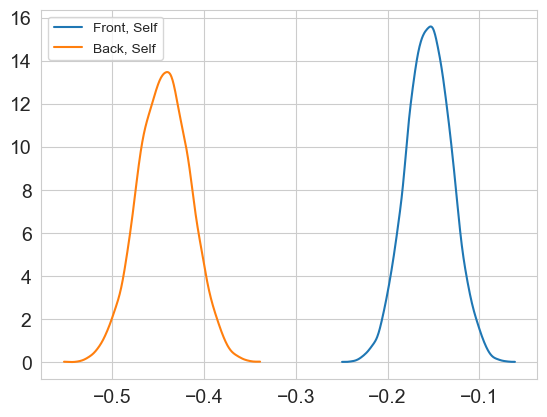

In [64]:
# _, ax = plt.subplots()
# for idx, x in enumerate([dem, ind]):
#     az.plot_dist(x, label=x["Location:Type_dim"].item(), plot_kwargs={"color": f"C{idx}"}, ax=ax)
# ax.legend(loc="upper left");

0.0

0.0

0.0

   Segment  Interaction  Log odds  Odds Ratio (exp(Δ))          %
0  Armpits        0.000    -1.518             0.219150 -78.085025
1    Chest        0.244    -0.480             0.618783 -38.121661
2     Feet       -0.089    -0.813             0.443525 -55.647451
3     Hair       -0.179    -0.903             0.405352 -59.464822
4    Hands       -0.031    -0.755             0.470011 -52.998939
5     Legs        0.263    -0.461             0.630653 -36.934732
6    Mouth        0.056    -0.668             0.512733 -48.726698
7     Neck        0.107    -0.617             0.539561 -46.043931
8   Pelvis        0.069    -0.655             0.519442 -48.055794


C:\Users\silva\AppData\Local\Temp\ipykernel_21884\2869165086.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gender_others = pd.concat([gender_others, pd.DataFrame([new_row])], ignore_index=True)


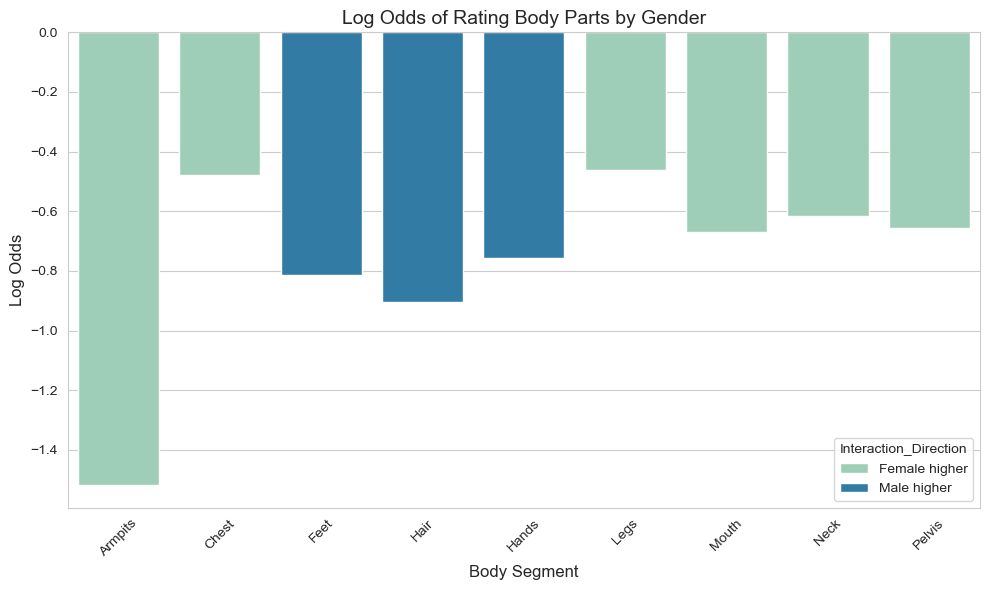

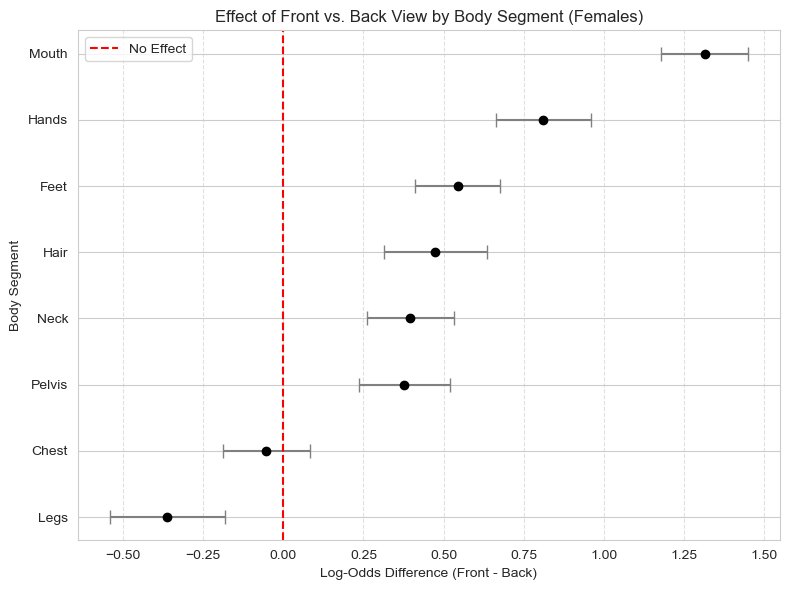